<a href="https://colab.research.google.com/github/ChoeTaeBin/Machine-Learnig/blob/main/airbnb_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

그냥 ordinal encoder는 훈련과정에서 보지못한 클래스의 값이 들어오면 에러가 납니다.   
그것을 해결하기위해서 category_encoder의 LeaveOneOutEncoder를 사용해 보려고 합니다.

In [59]:
!pip install category_encoders

In [60]:
pd.set_option("display.max_columns",None) #모든 columns을 보겠다고 설정함

In [61]:
org_df = pd.read_csv('/content/drive/MyDrive/Airbnb_Data.csv') #원본데이터

In [62]:
org_df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,NYC,one room in bushwick apt,NaN,t,t,NaN,2013-03-24,f,NaN,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,LA,"Located on the Pacific Coast Highway, this apa...",2016-08-15,t,f,100%,2016-05-03,f,2017-04-15,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,NYC,A modern apartment located in East Williamsbur...,2015-01-03,t,t,100%,2012-01-05,t,2017-09-10,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,NYC,"Fully renovated, designer's studio located in ...",NaN,t,f,100%,2017-09-17,t,NaN,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0


In [63]:
df = org_df.copy() #조작을 위해 복사본을 만든다.

콤마의 수를 세서 단어수를 세고 이를 num_amenityies에 저장

In [64]:
df['num_amenities'] = df['amenities'].apply(lambda x : x.count(',') + 1)

cancellation_pollicy는 의미있게 정수화함, 관대할 수록 높은 수를 가지게함

In [65]:

df.loc[(df['cancellation_policy'] == 'super_strict_30') | (df['cancellation_policy'] == 'super_strict_60') ,'cancellation_policy'] = 1
df.loc[df['cancellation_policy'] == 'strict','cancellation_policy'] = 2
df.loc[df['cancellation_policy'] == 'moderate','cancellation_policy'] = 3
df.loc[df['cancellation_policy'] == 'flexible','cancellation_policy'] = 4
df['cancellation_policy'].value_counts()

cancellation_policy
2    32374
4    22545
3    19063
1      129
Name: count, dtype: int64

우선 제 생각에 가격과 관련없다고 생각하는 feature들을 삭제했습니다.

In [66]:
df.drop(columns = ['id', 'description', 'name', 'thumbnail_url', 'zipcode', 'last_review', 'amenities','number_of_reviews', 'review_scores_rating', ], inplace = True)
df.columns

Index(['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'latitude',
       'longitude', 'neighbourhood', 'bedrooms', 'beds', 'num_amenities'],
      dtype='object')

타깃 데이터 분리

In [67]:
X = df.drop(columns = ['log_price']) #log_price를 제외한 나머지
y = df['log_price'] #log_price

테스트 데이터 분리

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42,)

imputer(NaN값을 처리해 주는 도구)

In [69]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

cat_imputer = make_pipeline(SimpleImputer(strategy = 'most_frequent')) #범주형은 최빈값으로 채움
num_imputer = make_pipeline(SimpleImputer(strategy = 'median')) #숫자형은 중앙값으로 채움

encoder(범주형 특성을 숫자화 해주는 도구)를 만들고 imputer와 연결해서 pipeline을 만듦

In [70]:
from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder

categorical_columns = X_train.columns[X_train.dtypes == 'object'] #범주형 특성 이름
numeric_columns = X_train.columns[X_train.dtypes != 'object'] #숫자형 특성 이름

cat_pipeline = Pipeline([
    ('encode', LeaveOneOutEncoder(handle_unknown='ignore')),
    ('impute', cat_imputer),
 ]) #범주형은 encoder를 추가

preprocessor = ColumnTransformer([
    ('num', num_imputer, numeric_columns),
    ('cat', cat_pipeline, categorical_columns)
]) #최종적 파이프라인

preprocessor.fit(X_train, y_train) #파이프라인을 훈련 시킴(이때 훈련 데이터로 훈련 시킴!)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['accommodates', 'bathrooms', 'cleaning_fee', 'latitude', 'longitude',
       'bedrooms', 'beds', 'num_amenities'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encode',
                                                  LeaveOneOutEncoder(handle_unknown='ignore')),
                                                 ('impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]))]),
                                 Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable',
       'neighbourhood'],
      dtype='object'))])

데이터 전처리(파이프라인 통과시키기)

In [71]:
processed_X_train = preprocessor.transform(X_train)
processed_X_test = preprocessor.transform(X_test)

전처리 잘 되었는지 확인

In [72]:
processed_X_train_df = pd.DataFrame(processed_X_train, columns = preprocessor.get_feature_names_out())

In [73]:
processed_X_train_df

,num__accommodates,num__bathrooms,num__cleaning_fee,num__latitude,num__longitude,num__bedrooms,num__beds,num__num_amenities,cat__property_type,cat__room_type,cat__bed_type,cat__cancellation_policy,cat__city,cat__first_review,cat__host_has_profile_pic,cat__host_identity_verified,cat__host_response_rate,cat__host_since,cat__instant_bookable,cat__neighbourhood
0,4.0,1.5,0.0,34.109039,-118.273390,2.0,3.0,17.0,4.789534,5.166411,4.79255,4.674676,4.716914,4.755421,4.779973,4.793916,4.831572,4.985082,4.79939,4.812239
1,2.0,1.0,1.0,40.812897,-73.919163,1.0,1.0,18.0,4.758986,5.166411,4.79255,4.888223,4.719742,4.579621,4.779973,4.793916,4.831572,4.240877,4.72753,4.324291
2,4.0,1.0,1.0,40.737643,-73.953309,0.0,2.0,11.0,4.758986,5.166411,4.79255,4.888223,4.719742,4.603167,4.779973,4.753426,4.763413,4.785257,4.72753,4.661398
3,2.0,1.0,1.0,37.759935,-122.420558,1.0,1.0,1.0,4.758986,4.327214,4.79255,4.674676,5.168569,4.905115,4.779973,4.793916,4.831572,4.861749,4.79939,5.107225
4,3.0,1.0,1.0,40.683363,-73.949490,1.0,1.0,13.0,4.758986,5.166411,4.79255,4.716900,4.719742,4.730810,4.779973,4.793916,4.763413,4.823465,4.79939,4.424497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59283,2.0,1.5,1.0,34.094867,-118.292013,1.0,1.0,16.0,4.758986,4.327214,4.79255,4.888223,4.716914,4.650877,4.779973,4.753426,4.724578,4.987117,4.79939,4.445599
59284,1.0,1.0,1.0,34.150509,-118.787469,1.0,1.0,16.0,4.789534,4.327214,4.79255,4.674676,4.716914,4.961665,4.779973,4.753426,4.763413,4.416163,4.79939,4.612521
59285,5.0,2.0,1.0,34.087073,-118.336914,2.0,2.0,18.0,4.789534,5.166411,4.79255,4.888223,4.716914,4.849996,4.779973,4.793916,4.613357,4.994624,4.79939,4.697703
59286,2.0,1.0,1.0,40.771579,-73.957856,1.0,1.0,21.0,4.758986,4.327214,4.79255,4.888223,4.719742,4.905115,4.779973,4.793916,4.763413,4.775282,4.79939,4.988009


random forest모델을 만들고 이를 이용해서 feature importance를 구한후 시각화

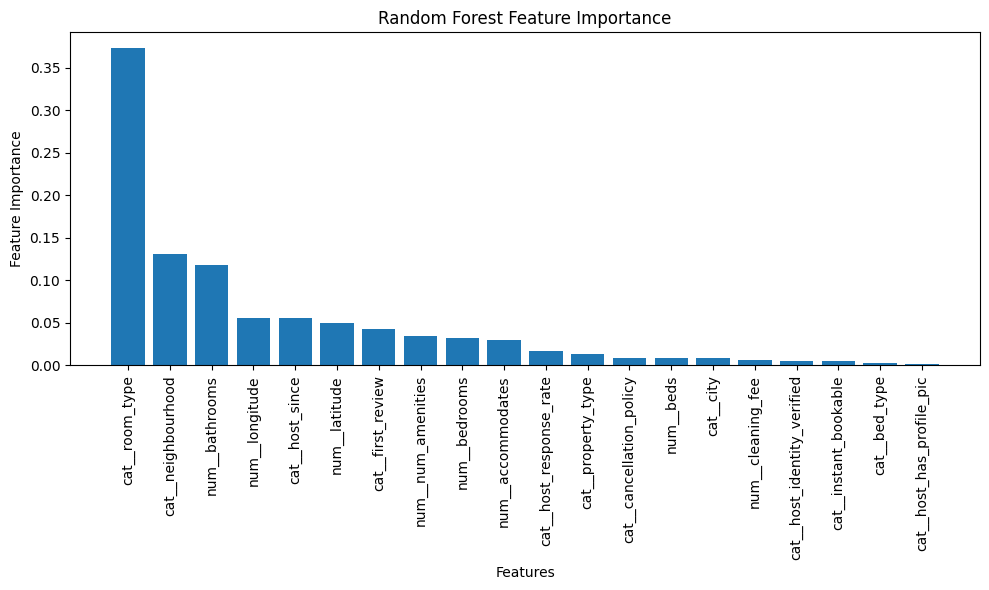

In [74]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# RandomForest 회귀 모델 생성
rf_reg_model = RandomForestRegressor()

# 모델 학습
rf_reg_model.fit(processed_X_train, y_train)

# 특성 중요도 얻기
feature_importance = rf_reg_model.feature_importances_

#특성 이름 리스트
feature_names = preprocessor.get_feature_names_out()

# 중요도가 높은 특성부터 내림차순으로 정렬합니다.
sorted_idx = feature_importance.argsort()[::-1]

# 특성 중요도를 그래프로 그립니다.
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

"중요도가 낮은 데이터를 더 삭제하면 점수가 높아지지 않을까?"   
라는 생각이 들어서 이를 확인 해 보기위해
중요도 순으로 데이터를 n개 선택할때 점수가 어떻게 달라지는지 분석 해 보았습니다.

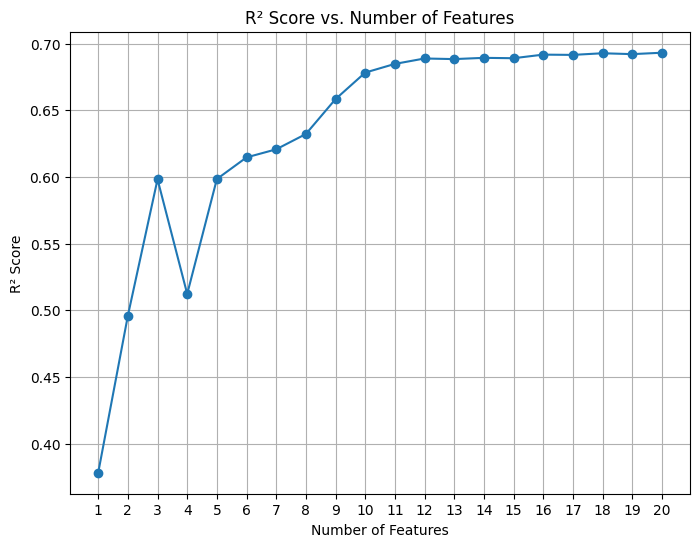

In [76]:
# n 값 리스트
n_values = np.arange(1,processed_X_train.shape[1]+1)

# 각 n 값에 대한 R² 스코어 저장
r2_scores = []

for n in n_values:
    # 상위 n개의 특성 인덱스 선택
    selected_features = sorted_idx[:n]

    # 선택된 특성으로 데이터 준비
    processed_X_train_selected = processed_X_train[:, selected_features]
    processed_X_test_selected = processed_X_test[:, selected_features]

    # RandomForest 회귀 모델 생성 및 학습
    rf_reg_model_selected = RandomForestRegressor()
    rf_reg_model_selected.fit(processed_X_train_selected, y_train)

    # 테스트 데이터로 예측 및 R² 스코어 계산
    y_pred_selected = rf_reg_model_selected.predict(processed_X_test_selected)
    r2_selected = r2_score(y_test, y_pred_selected)

    # R² 스코어 저장
    r2_scores.append(r2_selected)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(n_values, r2_scores, marker='o', linestyle='-')
plt.title('R² Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.xticks(n_values)
plt.grid(True)
plt.show()

대부분의 데이터들이 사용될때 더 좋은 결과를 나타낸다.  
-> 지금 선택한 데이터들은 모두 어느정도 유용하게 사용 된다는 것을 알 수 있습니다.